## Surprise: precision weighted prediction error

Now applying lateral competition for representation, i.e. subtract min(mu) from mu.

In [1]:
# %%
%cd ~/work/free-energy-minimization-framework/11/
%load_ext autoreload
%autoreload 2

# %%
import torch
from torch import nn
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
  x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
  x = x / np.sum(x)
  return torch.tensor(x).float()

def bhattacharya_distance(hist1,  hist2):
  hist1[hist1<0] = 0
  hist2[hist2<0] = 0

  a = 1 / (np.sum(hist1, axis=1) * np.sum(hist2, axis=1))
  b = np.sum(np.sqrt(hist1 * hist2), axis=1)
  return np.sqrt(1-a*b)

def imshow(title, image, vmin=0, vmax=1):
  plt.figure(figsize=figsize)
  plt.title("{2} [{0}, {1}]".format(np.amin(image), np.amax(image), title))
  plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
  plt.show()
    
def plot_errors(e):
    imshow('prediction errors', e, vmin=None, vmax=None)

    abs_errors = np.abs(e)
    imshow('abs_errors', abs_errors, vmin=None, vmax=None)

    positive_errors = errors.copy()
    positive_errors[positive_errors<0] = 0
    imshow('positive_errors', positive_errors, vmin=None, vmax=None)

    negative_errors = errors.copy()
    negative_errors[negative_errors>0] = 0
    negative_errors = negative_errors * -1
    imshow('negative_errors', negative_errors, vmin=None, vmax=None)

figsize=(15,5)
learning_rate = 0.01
quantization = 20

/Users/amolk/work/free-energy-minimization-framework/11


## Training pattern: sin() with a bit of noise, normal distribution around mean

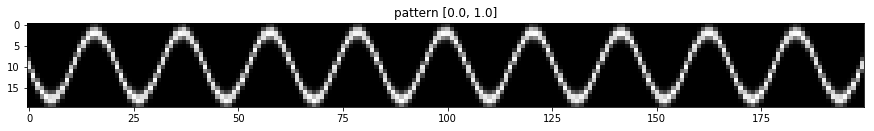

In [2]:
# %%
pattern_length = 200
pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.30) + 1.2 + np.random.sample(int(pattern_length)) * 0.03) / 2.5).float()
pattern = torch.stack([normal_distribution(quantization, val) for val in pattern_floats])
pattern = pattern / pattern.max().item() # normailze to probability distribution, i.e. sum = 1.0

imshow('pattern', pattern.t().numpy())

## Train an RNN to predict pattern

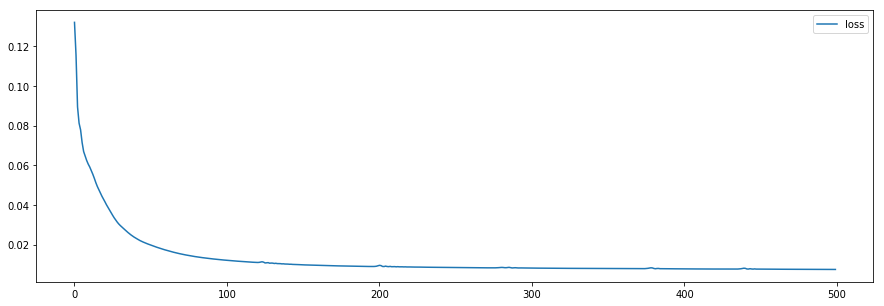

In [3]:
# %%
t_sample = 5
batch_size = pattern_length - t_sample - 1
input = torch.stack([pattern[i:i+t_sample] for i in np.arange(batch_size)])
target = torch.stack([pattern[i+1:i+t_sample+1] for i in np.arange(batch_size)])

hidden_size = t_sample

# %%
num_layers=4
rnn = nn.RNN (
  input_size=quantization,
  hidden_size=quantization,
  num_layers=num_layers,
  nonlinearity='tanh',
  batch_first=True
)

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
epoch = 0
losses = []
while epoch < 500:
  rnn.zero_grad()
  state = torch.zeros(num_layers, batch_size, quantization)
  out, state = rnn(input, state)
  # out = linear(out)
  # print('out', out)
  # print('state', state)
  #torch.nn.functional.relu_(out)
  loss = torch.nn.functional.mse_loss(out, target)
  loss.backward()
  optimizer.step()
  # print('loss', loss)
  losses.append(loss)
  epoch += 1

plt.figure(figsize=figsize)
plt.plot(losses, label='loss')
plt.legend()
plt.show()

## Test with training pattern

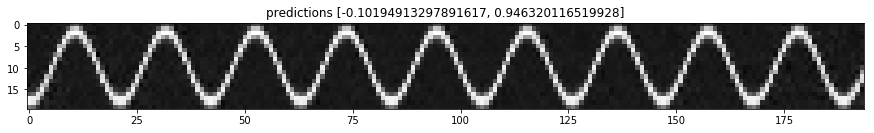

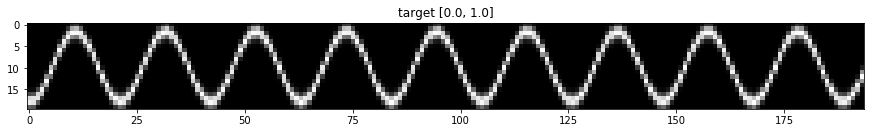

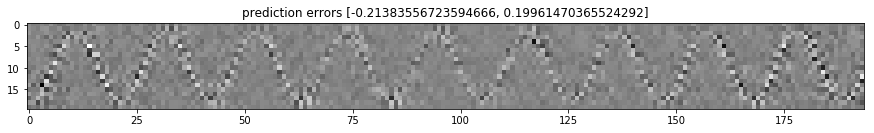

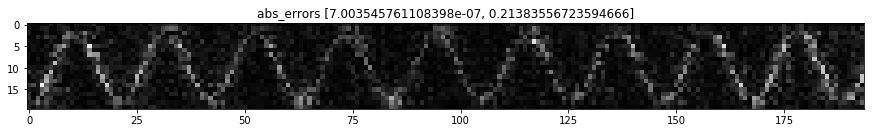

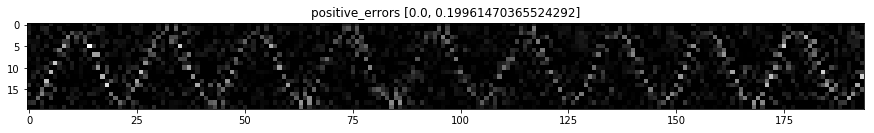

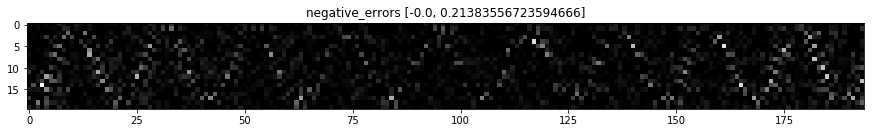

In [4]:
state = torch.zeros(num_layers, batch_size, quantization)
out, state = rnn(input, state)

predictions = out[:, -1].detach().numpy()
#predictions[predictions<0] = 0
predictions = predictions.transpose()
imshow('predictions', predictions, vmin=None, vmax=None)

target_predictions = target[:, -1, :].t().numpy()
imshow('target', target_predictions, vmin=None, vmax=None)

errors = target_predictions - predictions
plot_errors(errors)



## Test pattern (piecewise sin)

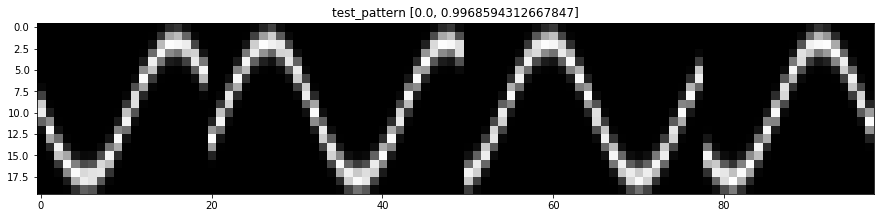

In [5]:
# %%
test_pattern = torch.cat([pattern[0:int(pattern_length*0.10)], pattern[int(pattern_length*0.15):int(pattern_length*0.30)], pattern[int(pattern_length*0.45):int(pattern_length*0.59)], pattern[int(pattern_length*0.85):int(pattern_length*0.95)]])
test_pattern_length = test_pattern.shape[0]
imshow('test_pattern', test_pattern.t().numpy())
test_batch_size = test_pattern_length - t_sample - 1
test_input = torch.stack([test_pattern[i:i+t_sample] for i in np.arange(test_batch_size)])
test_target = torch.stack([test_pattern[i+1:i+t_sample+1] for i in np.arange(test_batch_size)])

## Sample output of RNN

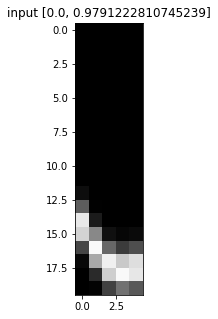

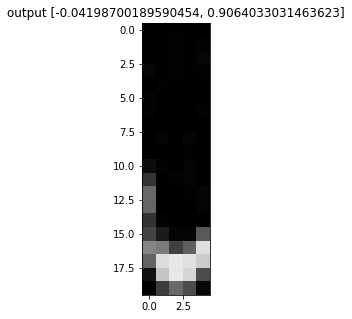

In [6]:
# %%
state = torch.zeros(num_layers, test_batch_size, quantization)
out, state = rnn(test_input, state)
#torch.nn.functional.relu_(out)

index = 34
imshow('input', test_input[index].detach().t().numpy())
imshow('output', out[index].detach().t().numpy())

## Predictions, precision weighting

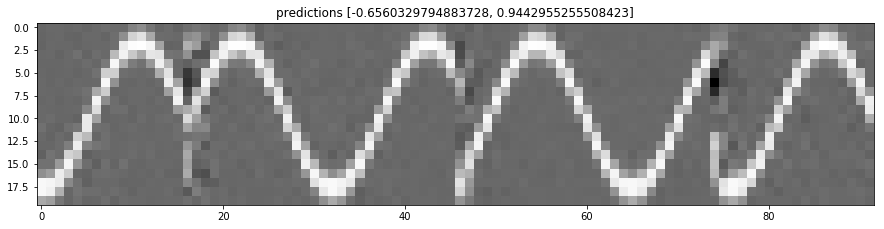

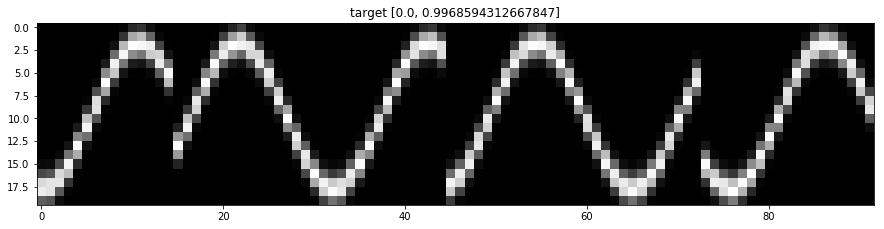

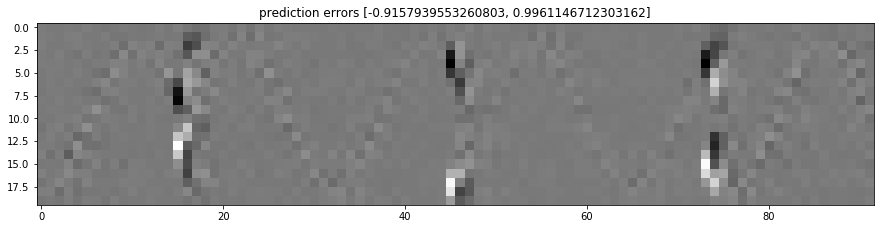

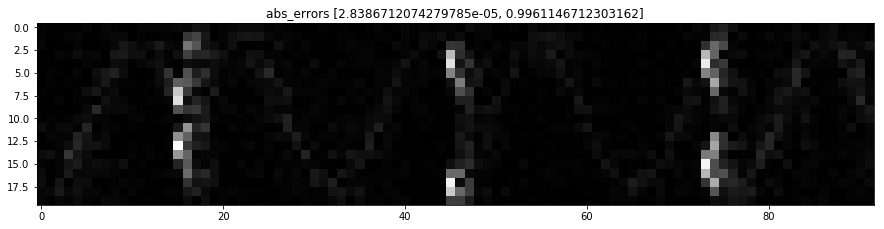

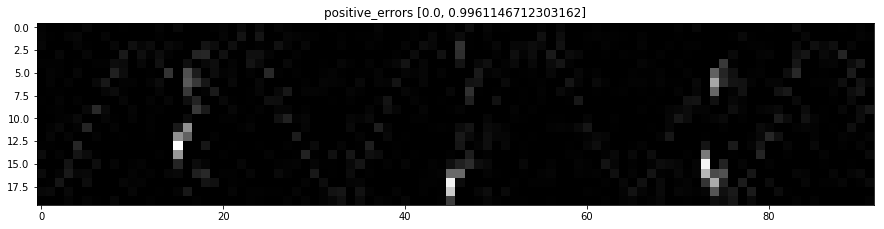

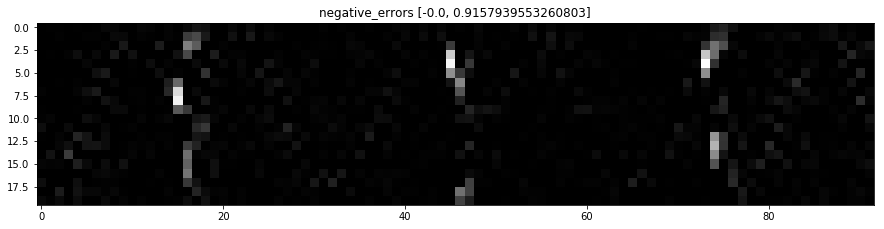

In [7]:

# last entry in out is the prediction
predictions = out[:, -1].detach().numpy()
#predictions[predictions<0] = 0
predictions = predictions.transpose()
imshow('predictions', predictions, vmin=None, vmax=None)

#predictions = predictions - np.min(predictions, 0)
#imshow('normalized predictions', predictions, vmin=None, vmax=None)

target_predictions = test_target[:, -1, :].t().numpy()
imshow('target', target_predictions, vmin=None, vmax=None)

errors = target_predictions - predictions
plot_errors(errors)



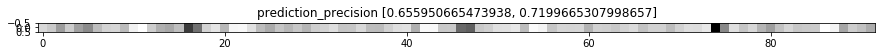

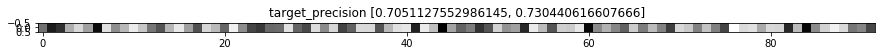

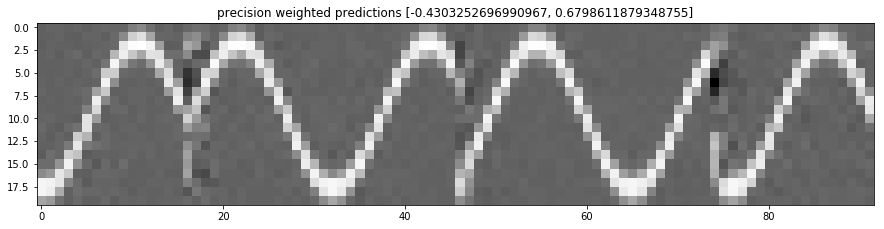

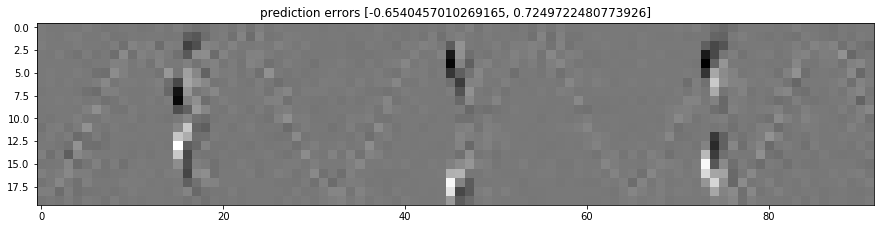

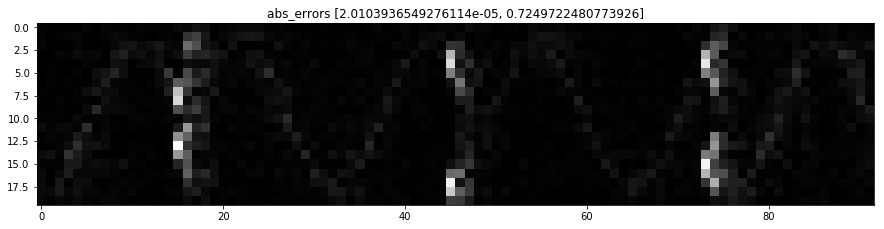

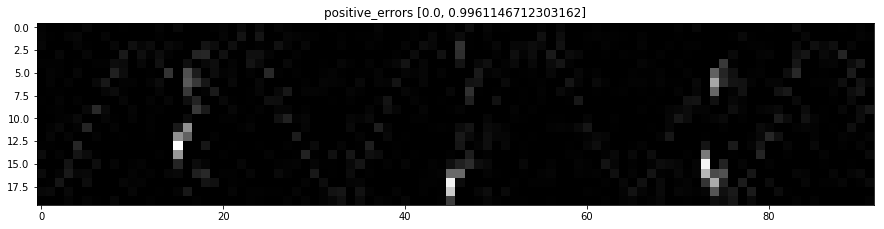

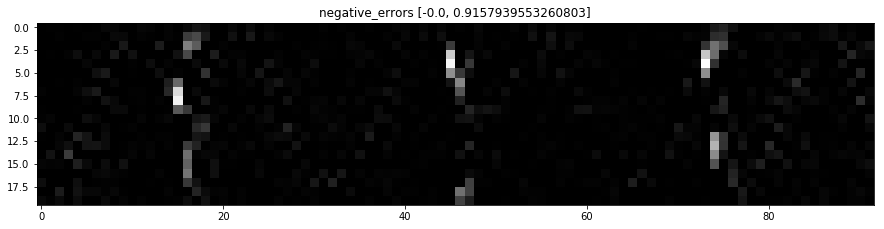

In [8]:
def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))

normalized_predictions = sigmoid_array(predictions)
prediction_precision = np.max(normalized_predictions, axis=0)
imshow('prediction_precision', [prediction_precision], vmin=None, vmax=None)

normalized_target_predictions = sigmoid_array(target_predictions)
target_precision = np.max(normalized_target_predictions, axis=0)
imshow('target_precision', [target_precision], vmin=None, vmax=None)

precision_weighted_predictions = predictions * prediction_precision
imshow('precision weighted predictions', precision_weighted_predictions, vmin=None, vmax=None)

precision_weighted_errors = target_predictions * target_precision - precision_weighted_predictions
#precision_weighted_errors[precision_weighted_errors<0] = 0
plot_errors(precision_weighted_errors)

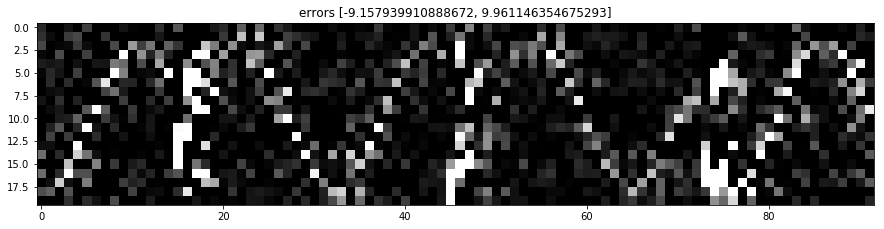

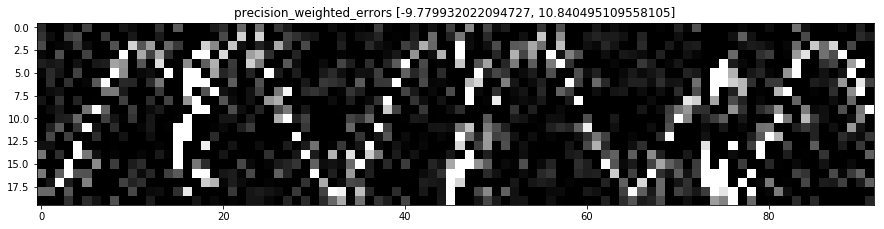

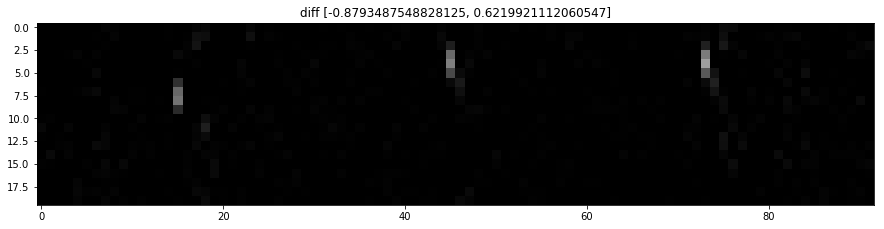

In [9]:
imshow('errors', (errors) * 10)
imshow('precision_weighted_errors', (precision_weighted_errors) * 10 * 7.0279 / 4.7)
imshow('diff', (errors) * 10 - (precision_weighted_errors) * 10 * 7.0279 / 4.7)

I don't see much difference between precision weighted and normal prediction errors. Maybe this prob-distribution representation inherantly calculates errors with precision weighting?!

The simple sin wave is too easy for the RNN to learn so there is no partial learning in the single layer we have here. Only surprise gets passed up.

Next step would be to use a more complex function that single layer cannot learn or there is inherant ambiguity without long context (longer than t_sample of the single layer). We will also need to look at how mu_hat, mu_bar and mu interact, and how to compute mu_next, how to afford longer t_sample for higher layer.